This python notebook is for extracting data from vibrastic labview vibration measurement data application

Necessary library loaded from this section

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import csv
import numpy as np
import sys
import tkinter as tk
import pandas as pd
from tkinter import filedialog
from additional_functions import *

from scipy.signal import find_peaks


Select measurement data using procedure as follows

In [3]:
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
fs = 25600 #input frequency sampling as measured

file_path = filedialog.askopenfilename(multiple=False)
%gui tk

Collect data and store into arrays

In [4]:
file = open(file_path)
type(file)
t, s0, s1, s2, s3 = ([], [], [], [], [])

for line in file:
    splitrow = line.rstrip().split("	")
    t.append(float(splitrow[0].replace(",", ".")))
    s0.append(float(splitrow[1].replace(",", ".")))
    s1.append(float(splitrow[2].replace(",", ".")))
    s2.append(float(splitrow[3].replace(",", ".")))
    s3.append(float(splitrow[4].replace(",", ".")))

data = np.array([s0, s1, s2, s3])
#note that this process convert measured data into array

The following step is just for units conversion, you may edit if you want to reverse it

In [1]:
# Convert acceleration data units from m/s^2 to g
g_converter = 9.80665   # a constant, 1 g ~ 9.80665 m/s^2 
sensor_0 = np.asarray(s0)/g_converter

NameError: name 'np' is not defined

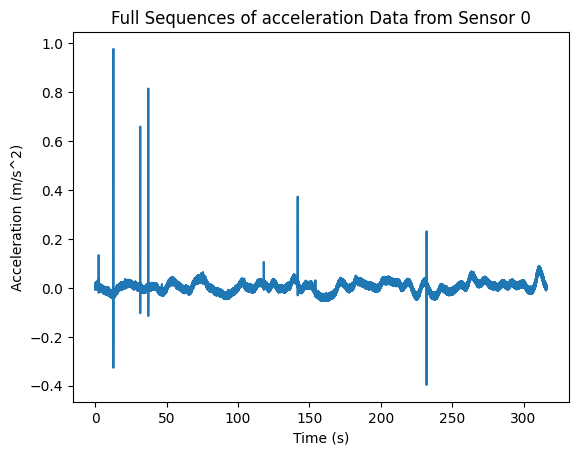

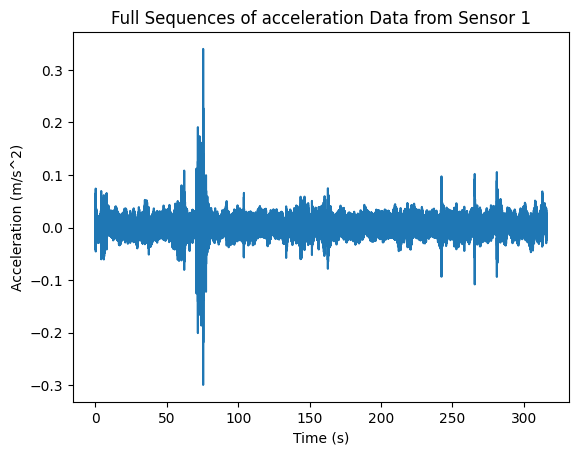

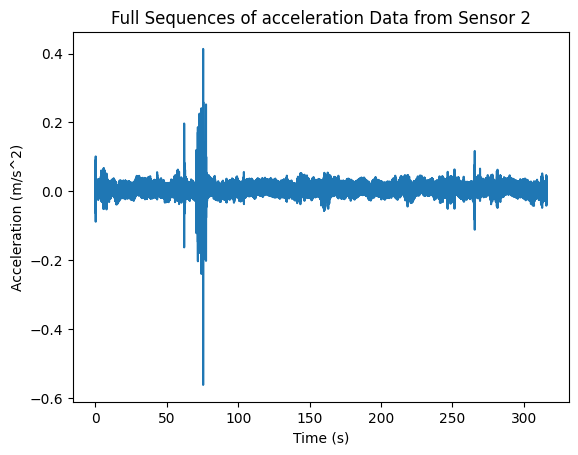

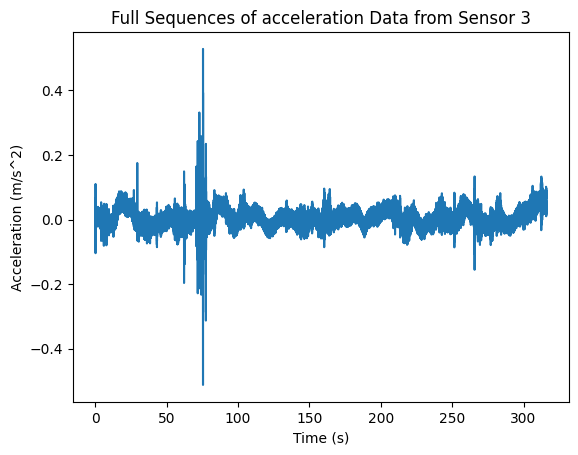

In [5]:
for i in range(len(data)):
    plt.figure()
    plt.plot(t,data[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Full Sequences of acceleration Data from Sensor "+str(i))

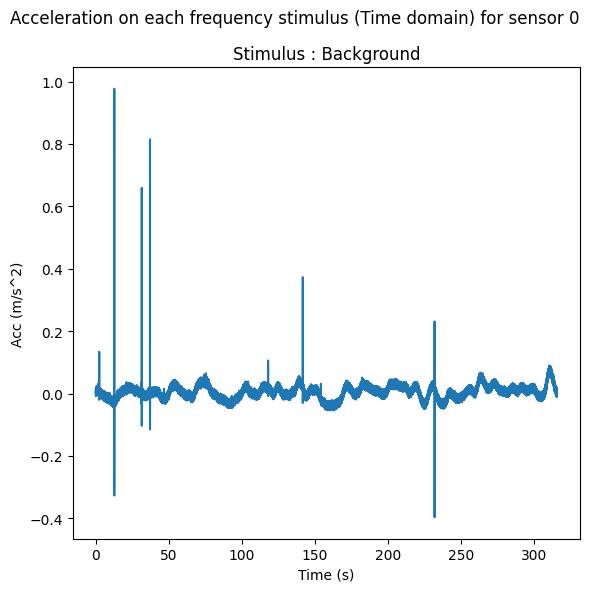

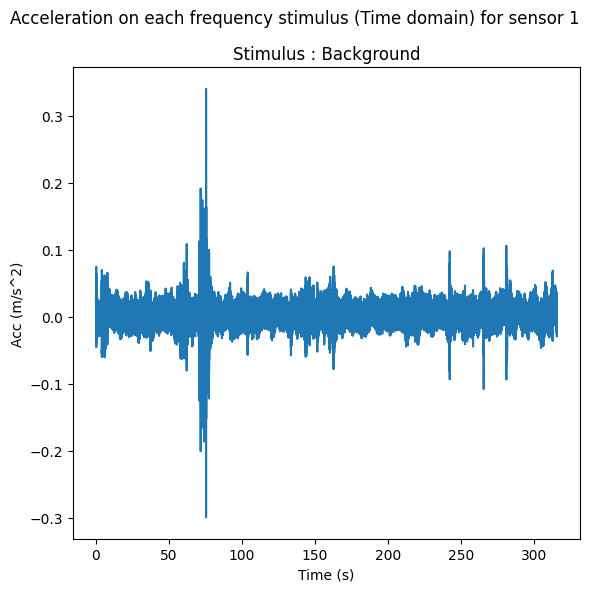

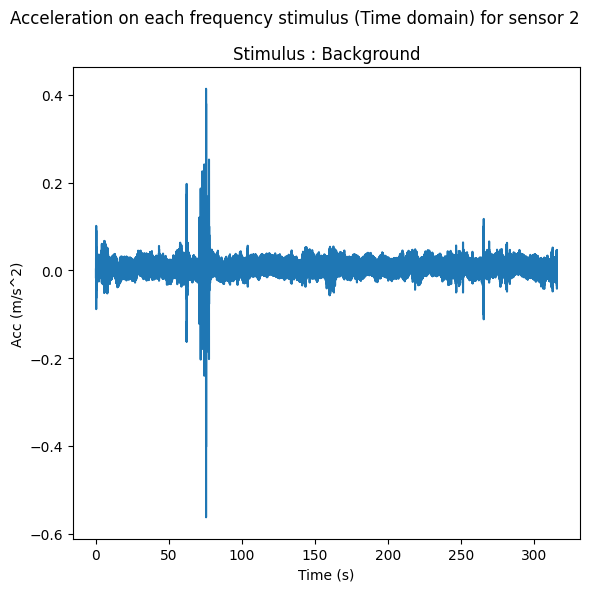

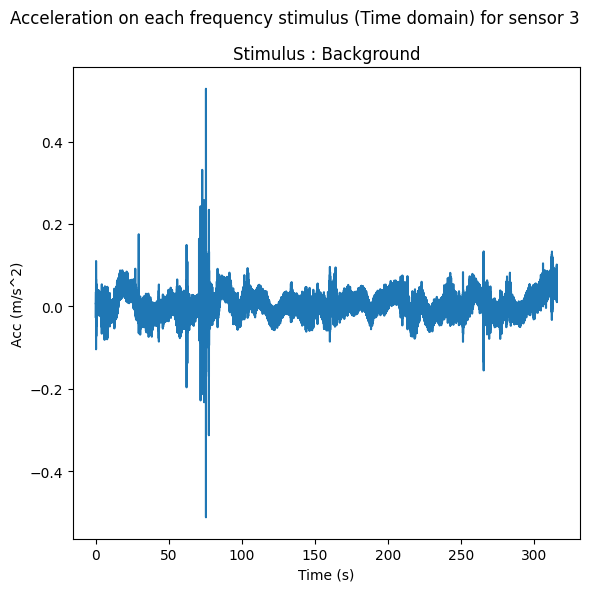

In [6]:
ni_fs = 25600
freq_stimulus = ["Background"]
datapoints = [
    [0*ni_fs, 360*ni_fs],
    ]

segmented_data = []
for i in range(len(data)):
    segmented_data.append(segmenting_data(data[i], datapoints))

# interpret acceleration in time domain data for each frequencies
for pivot in range(len(segmented_data)):
    plt.figure(figsize=(6,6), tight_layout=True)
    plt.suptitle("Acceleration on each frequency stimulus (Time domain) for sensor "+str(pivot))
    for i in range(len(datapoints)):
        plt.subplot(len(datapoints),1,i+1)
        plt.plot(t[datapoints[i][0]:datapoints[i][1]], segmented_data[pivot][i])
        plt.xlabel("Time (s)")
        plt.ylabel("Acc (m/s^2)")
        plt.title("Stimulus : " + freq_stimulus[i])


plt.show()

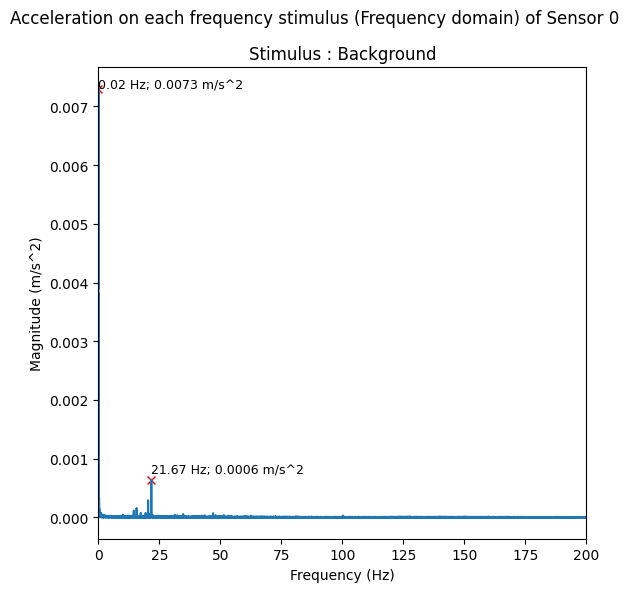

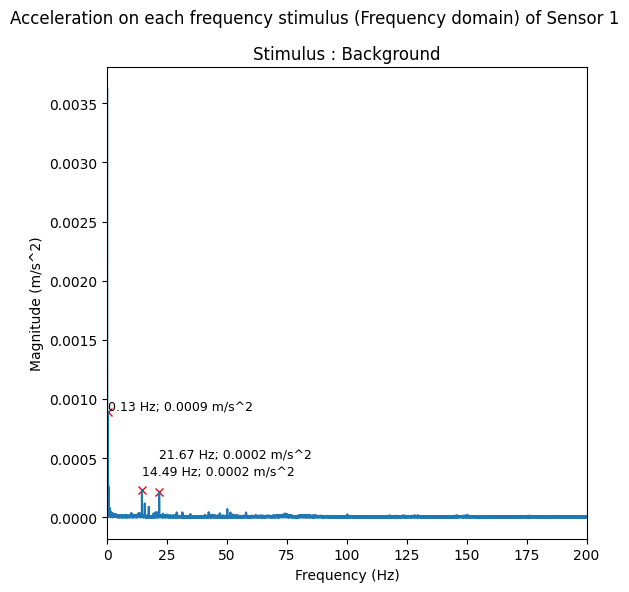

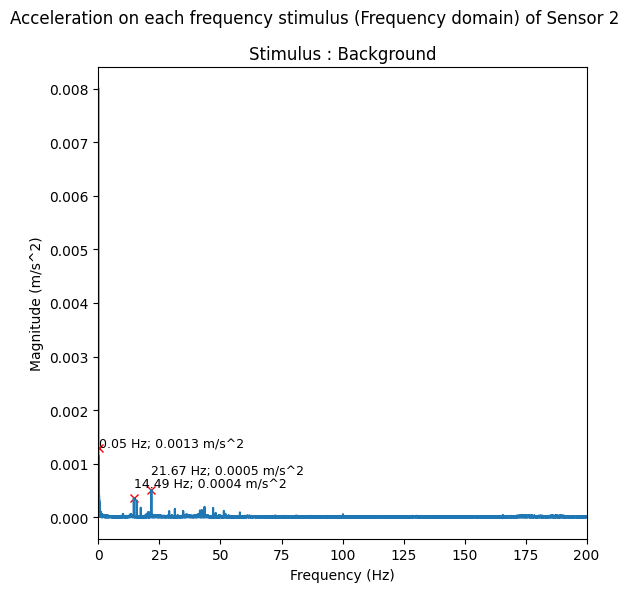

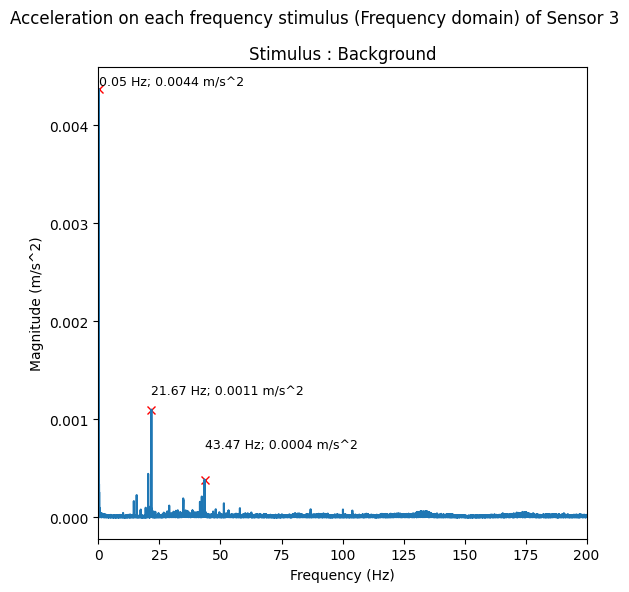

In [7]:
## Transforming segmented data to frequency domain using Fast-Fourier Transform
for pivot in range(len(segmented_data)):
    plt.figure(figsize=(6,6), tight_layout=True)
    plt.suptitle("Acceleration on each frequency stimulus (Frequency domain) of Sensor "+str(pivot))
    for i in range(len(datapoints)):
        plt.subplot(len(datapoints),1,i+1)
        
        # applying FFT
        acc = segmented_data[pivot][i]
        nfft = int(pow(2, np.ceil(np.log2(len(acc)))))
        win = np.hamming(len(acc))
        freq = (ni_fs/2) * np.arange(0,1,1/(nfft/2+1))

        ACC = 2/len(acc) * np.fft.fft(win*acc, nfft)

        data = abs(ACC)[0:int(nfft/2+1)]

        peaks, _ = find_peaks(data, height=0.0002, distance=2000)
        plt.plot(freq[peaks], data[peaks], 'rx')

        trunkx = 0
        trunky = 0
        for x, y in zip(np.round(freq[peaks],2), np.round(data[peaks],4)):
            # plt.annotate(str(x) + " Hz; " + str(y) + " m/s^2", xy=(x,y+0.0001), fontsize=9)
            # plt.annotate(str(y) + " m/s^2", xy=(x,y), fontsize=9)
            plt.annotate(str(x) + " Hz; " + str(y) + " m/s^2", xy=(x-trunkx,y+trunky), fontsize=9)
            trunkx = trunkx + 0.001
            if y+1 > y:
                trunky = trunky + 0.00015
            else:
                trunky = trunky - 0.00015

        plt.plot(freq, abs(ACC)[0:int(nfft/2+1)])
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (m/s^2)")
        plt.xlim([0, 200])
        plt.title("Stimulus : " + freq_stimulus[i])

plt.show()

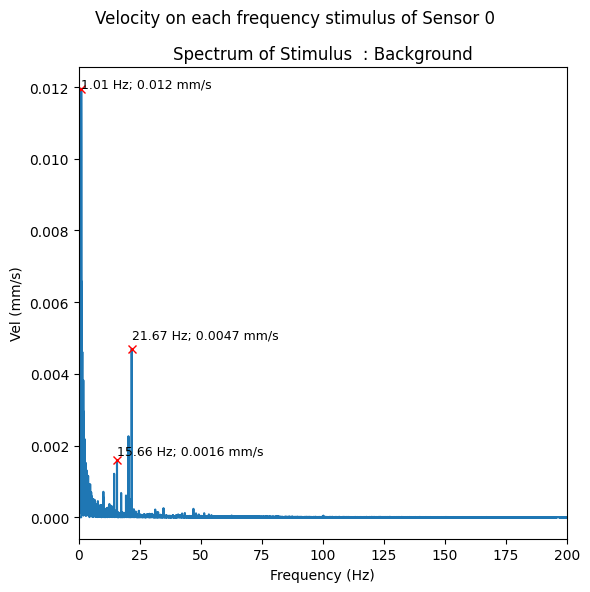

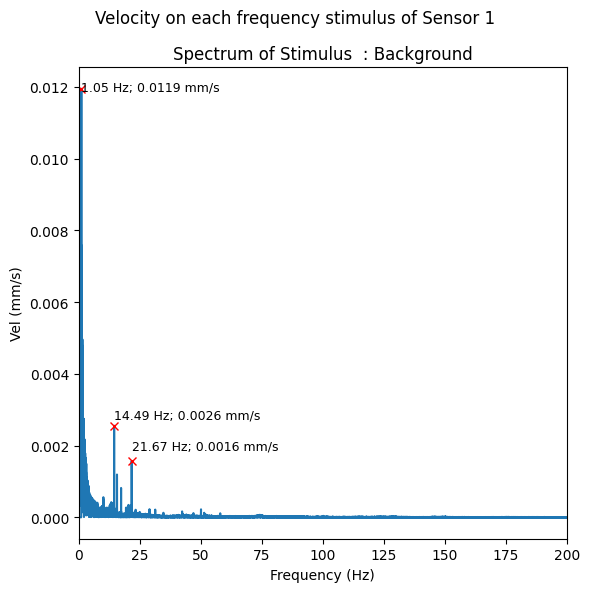

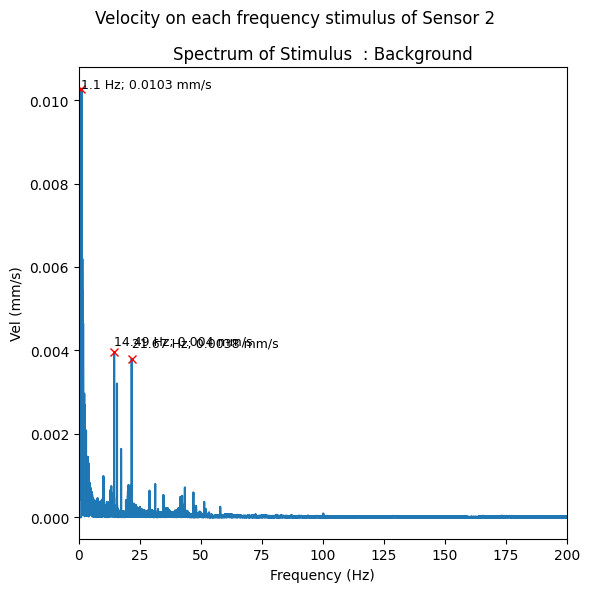

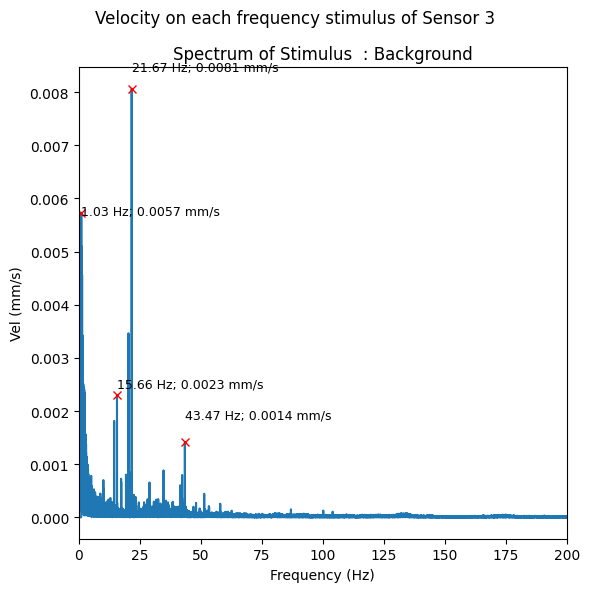

In [9]:
# Convert each acceleration (segmented) data into velocity units
vel = []
cf_frequency = 1
for pivot in range(len(segmented_data)):
    plt.figure(figsize=(6,6), tight_layout=True)
    plt.suptitle("Velocity on each frequency stimulus of Sensor "+str(pivot))

    for i in range(len(datapoints)):
        plt.subplot(len(datapoints),1,i+1)
        
        vel_data, VEL_data, _, _, freq_data = convert_units(segmented_data[pivot][i], ni_fs, cf_frequency)
        vel.append(vel_data)

        data = abs(VEL_data)[0:int(nfft/2+1)]*1e3
        plt.plot(freq_data, data)

        peaks, _ = find_peaks(data, height=0.001, distance=1000)
        plt.plot(freq_data[peaks], data[peaks], 'rx')
        trunkx = 0
        trunky = 0
        for x, y in zip(np.round(freq[peaks],2), np.round(data[peaks],4)):
            # plt.annotate(str(x) + " Hz; " + str(y) + " m/s^2", xy=(x,y+0.0001), fontsize=9)
            # plt.annotate(str(y) + " m/s^2", xy=(x,y), fontsize=9)
            plt.annotate(str(x) + " Hz; " + str(y) + " mm/s", xy=(x-trunkx,y+trunky), fontsize=9)
            trunkx = trunkx + 0.001
            if y+1 > y:
                trunky = trunky + 0.00015
            else:
                trunky = trunky - 0.00015
       

        # plt.subplot(len(segmented_data), 2, 2*i+1)
        # plt.plot(t[datapoints[i][0]:datapoints[i][1]], vel_data*1e3)
        # plt.xlabel("Time (s)")
        # plt.ylabel("Vel (mm/s)")
        # plt.title("Waveform of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

        # plt.subplot(len(segmented_data), 2, 2*(i+1))
        # plt.plot(freq_data, abs(VEL_data)*1e3)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Vel (mm/s)")
        plt.xlim([0, 200])
        plt.title("Spectrum of Stimulus  : " + freq_stimulus[i])

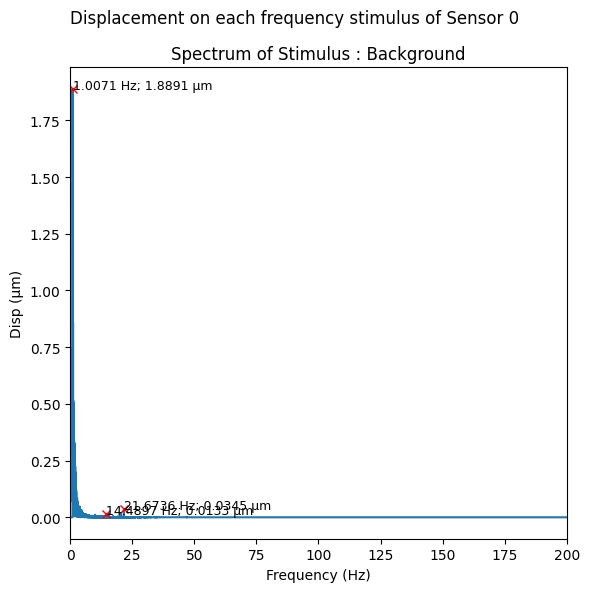

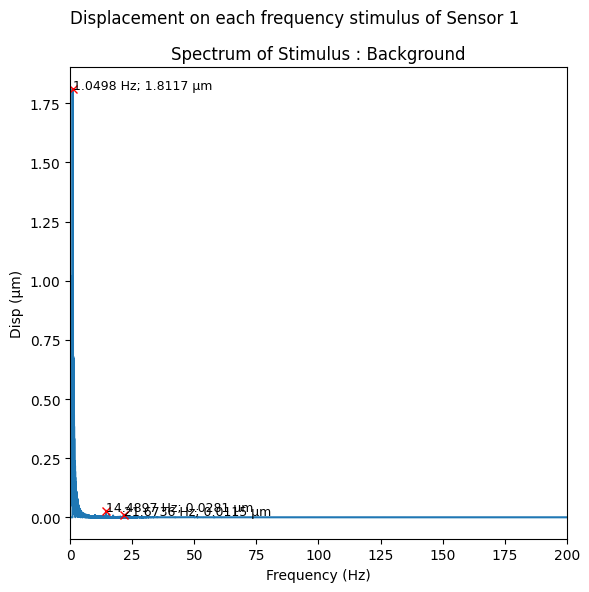

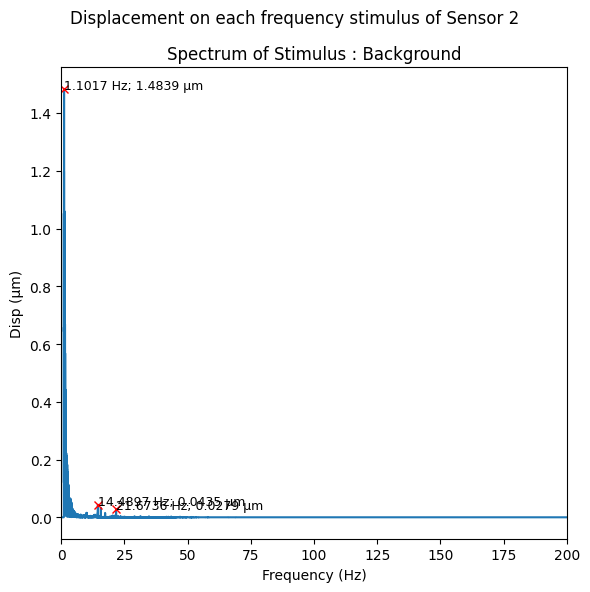

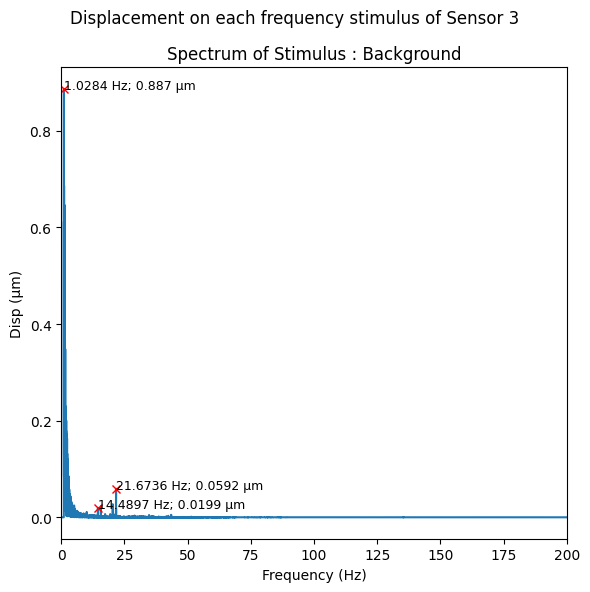

In [11]:
# Convert each velocity (segmented) data into displacement units
disp = []
cf_frequency = 1
trunk = 0
for pivot in range(len(segmented_data)):
    plt.figure(figsize=(6,6), tight_layout=True)
    plt.suptitle("Displacement on each frequency stimulus of Sensor "+str(pivot))

    for i in range(len(datapoints)):
        plt.subplot(len(datapoints),1,i+1)
        _, _, disp_data, DISP_data, freq_data = convert_units(segmented_data[pivot][i], ni_fs, cf_frequency)
        # print(str(trunk))
        trunk = trunk + 1
        disp.append(disp_data)

        data = abs(DISP_data)[0:int(nfft/2+1)]*1e6
        plt.plot(freq_data, data)

        peaks, _ = find_peaks(data, height=0.01, distance=2000)
        plt.plot(freq_data[peaks], data[peaks], 'rx')

        trunkx = 0
        trunky = 0
        freq_plot = []
        disp_plot = []
        for x, y in zip(np.round(freq_data[peaks],4), np.round(data[peaks],4)):
            plt.annotate(str(x) + " Hz; " +str(y) + " μm", xy=(x-trunkx,y+trunky), fontsize=9)
            # plt.annotate(str(x) + " Hz; " + str(y) + " $\mu$m", xy=(x+3,y-0.2), fontsize=9)
            freq_plot.append(x)
            disp_plot.append(y)
            trunkx = trunkx + 0.001
            if y+1 > y:
                trunky = trunky + 0.00015
            else:
                trunky = trunky - 0.00015
        # plt.subplot(len(segmented_data), 2, 2*i+1)
        # plt.plot(t[datapoints[i][0]:datapoints[i][1]], disp_data*1e6)
        # plt.xlabel("Time (s)")
        # plt.ylabel("Disp (μm)")
        # plt.title("Waveform of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

        # plt.subplot(len(segmented_data), 2, 2*(i+1))
        # plt.plot(freq_data, abs(DISP_data)*1e6)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Disp (μm)")
        plt.xlim([0, 200])
        plt.title("Spectrum of Stimulus : " + freq_stimulus[i])

In [44]:
print(disp_plot)
print(freq_plot)

[0.0407, 0.0127, 0.0279, 0.0671]
[21.6736, 21.6736, 21.6736, 21.6736]


In [43]:
for pivot in range(len(segmented_data)):
    for i in range(len(datapoints)):
        print("Sensor "+str(pivot)+" with stimulus "+str(freq_stimulus[i])+" has Acceleration RMS = "+str(round(np.sqrt(np.mean(segmented_data[pivot][i]**2)),3))+" m/s^2. Peak to Peak = "+str(round(max(segmented_data[pivot][i]) - min(segmented_data[pivot][i]),3))+" m/s^2, Peak = "+str(round(max(abs(segmented_data[pivot][i])),3))+" m/s^2")

Sensor 0 with stimulus Music has Acceleration RMS = 0.006 m/s^2. Peak to Peak = 0.059 m/s^2, Peak = 0.033 m/s^2
Sensor 1 with stimulus Music has Acceleration RMS = 0.009 m/s^2. Peak to Peak = 0.217 m/s^2, Peak = 0.113 m/s^2
Sensor 2 with stimulus Music has Acceleration RMS = 0.008 m/s^2. Peak to Peak = 0.172 m/s^2, Peak = 0.089 m/s^2
Sensor 3 with stimulus Music has Acceleration RMS = 0.011 m/s^2. Peak to Peak = 0.18 m/s^2, Peak = 0.1 m/s^2


In [13]:
# Obtain RMS, Peak to Peak, and Peak Value of Velocity units
rms_vel = []
pp_vel = []
peak_vel = []
trunk = 0
for pivot in range(len(segmented_data)):
    for i in range(len(datapoints)):
        rms = np.sqrt(np.mean(np.real(vel[trunk]*1e3)**2))
        rms_vel.append(rms)

        pp = max(np.real(vel[trunk]*1e3)) - min(np.real(vel[trunk]*1e3))
        pp_vel.append(pp)

        peak = max(abs(np.real(vel[trunk]*1e3)))
        peak_vel.append(peak)
        trunk = trunk +1
        print("Velocity of Sensor "+str(pivot)+" at " + freq_stimulus[i] + " Stimulus has RMS = " + str(round(rms,3)) + " mm/s, Peak to Peak = " + str(round(pp,3)) + " mm/s, Peak = " + str(round(peak,3)) + " mm/s")

Velocity of Sensor 0 at Music Hz has RMS = 0.011 mm/s, Peak to Peak = 0.106 mm/s, Peak = 0.055 mm/s
Velocity of Sensor 1 at Music Hz has RMS = 0.007 mm/s, Peak to Peak = 0.097 mm/s, Peak = 0.046 mm/s
Velocity of Sensor 2 at Music Hz has RMS = 0.014 mm/s, Peak to Peak = 0.125 mm/s, Peak = 0.081 mm/s
Velocity of Sensor 3 at Music Hz has RMS = 0.021 mm/s, Peak to Peak = 0.184 mm/s, Peak = 0.133 mm/s


In [18]:
# Obtain RMS, Peak to Peak, and Peak Value of Displacement units
rms_disp = []
pp_disp = []
peak_disp = []
trunk = 0
for pivot in range(len(segmented_data)):
    for i in range(len(datapoints)):
        rms = np.sqrt(np.mean(np.real(disp[trunk]*1e6)**2))
        rms_disp.append(rms)

        pp = max(np.real(disp[trunk]*1e6)) - min(np.real(disp[trunk]*1e6))
        pp_disp.append(pp)

        peak = max(abs(np.real(disp[trunk]*1e6)))
        peak_disp.append(peak)
        trunk = trunk +1
        print("Displacement of Sensor "+str(pivot)+" at " + freq_stimulus[i] + " Stimulus has RMS = " + str(round(rms,3)) + " μm, Peak to Peak = " + str(round(pp,3)) + " μm, Peak = " + str(round(peak,3)) + " μm")

Displacement of Sensor 0 at Music Stimulus has RMS = 0.069 μm, Peak to Peak = 0.58 μm, Peak = 0.297 μm
Displacement of Sensor 1 at Music Stimulus has RMS = 0.029 μm, Peak to Peak = 0.279 μm, Peak = 0.144 μm
Displacement of Sensor 2 at Music Stimulus has RMS = 0.063 μm, Peak to Peak = 0.754 μm, Peak = 0.398 μm
Displacement of Sensor 3 at Music Stimulus has RMS = 0.118 μm, Peak to Peak = 1.303 μm, Peak = 0.692 μm


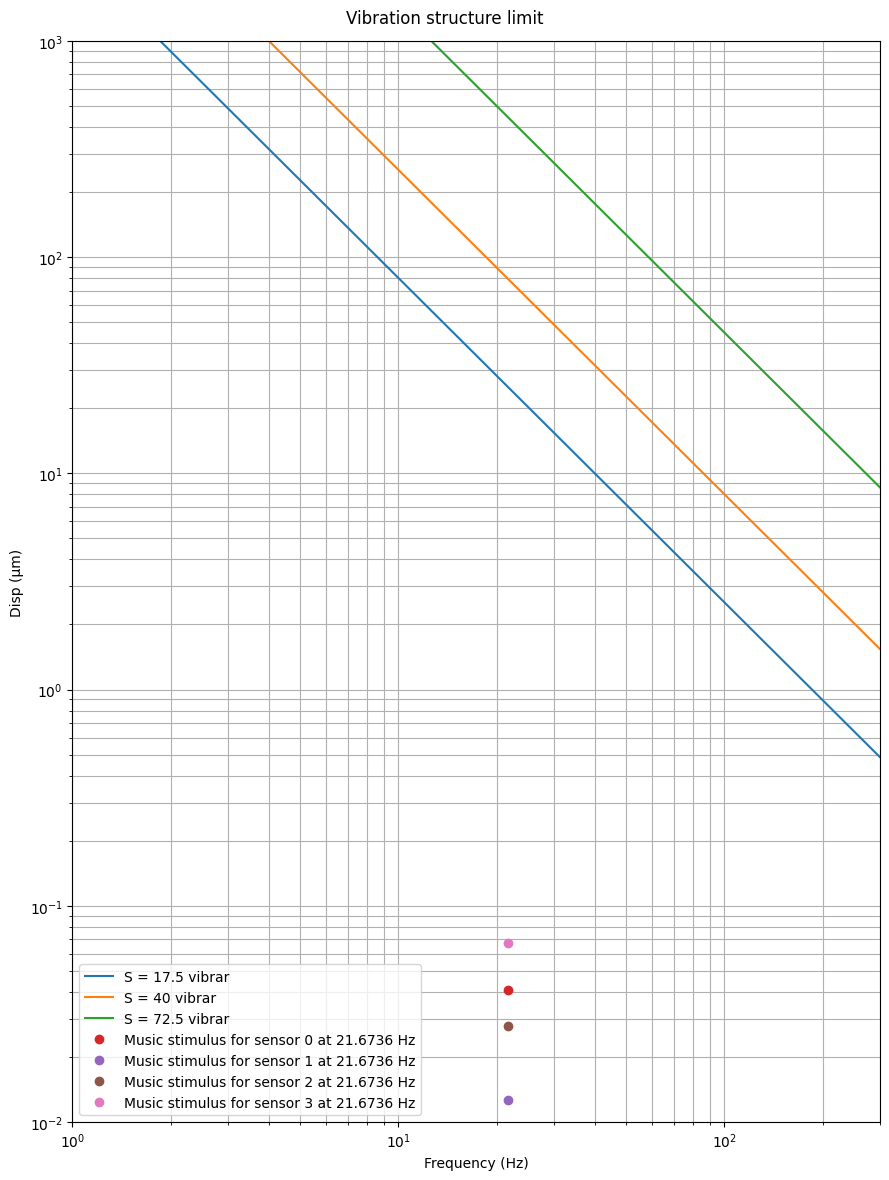

In [46]:
# Interpret the displacement result on graph (on progress)
vib_limit = [6.4, 64, 2000]    # limits on mm^2 / s^3
legend_limit = ["S = 17.5 vibrar", "S = 40 vibrar", "S = 72.5 vibrar"]
freq_limit = np.linspace(1, 1000, 1000)

disp_limit = [0.0407, 0.0127, 0.0279, 0.0671]

plt.figure(figsize=(9,12), tight_layout=True)
plt.suptitle("Vibration structure limit")

line_lim = []
for i in range(len(vib_limit)):
    data = []
    for f in range(len(freq_limit)):
        x = np.sqrt(vib_limit[i] / (pow(freq_limit[f],3)) )
        x = x*1e3   # Change displacement units from mm into micron
        data.append(x)
    line_lim.append(data)
    plt.plot(freq_limit, data)

    plt.yscale('log')
    plt.ylim([0.01, 1000])
    plt.ylabel("Disp (μm)")
    plt.xscale('log')
    plt.xlim([1, 300])
    plt.xlabel("Frequency (Hz)")
    
# plot displacement from measured result

for i in range(len(disp_limit)):
    plt.plot((freq_plot[i]), disp_limit[i], 'o')

legend_data = [str("Music stimulus for sensor "+str(i) +" at " + str(freq_plot[i]) + " Hz") for i in range(len(freq_plot))]

plt.legend(legend_limit + legend_data)
plt.grid(True, which='both')